In [ ]:
!pip install diffusers transformers accelerate scipy safetensors
!pip install carvekit

In [ ]:
import json
from typing import List
import requests as r
import base64
from io import BytesIO
import json

from PIL import Image

from carvekit.api.interface import Interface
from carvekit.ml.wrap.fba_matting import FBAMatting
from carvekit.ml.wrap.tracer_b7 import TracerUniversalB7
from carvekit.pipelines.postprocessing import MattingMethod
from carvekit.pipelines.preprocessing import PreprocessingStub
from carvekit.trimap.generator import TrimapGenerator

import cv2
import numpy as np

import requests
from diffusers.utils import make_image_grid, load_image

from diffusers import StableDiffusionInpaintPipeline
import torch

import matplotlib.pyplot as plt

In [ ]:
# Carvekit initialization
seg_net = TracerUniversalB7(device="cpu", batch_size=1)

fba = FBAMatting(device="cpu", input_tensor_size=2048, batch_size=1)

trimap = TrimapGenerator()

preprocessing = PreprocessingStub()

postprocessing = MattingMethod(
    matting_module=fba, trimap_generator=trimap, device="cpu"
)

carvekit_processor = Interface(
    pre_pipe=preprocessing, post_pipe=postprocessing, seg_pipe=seg_net
)

In [ ]:
# Stable diffusion initialization
model_id = "stabilityai/stable-diffusion-2-1"
# model_id = "runwayml/stable-diffusion-inpainting"
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    model_id,
    revision="fp16",
    torch_dtype=torch.float16,
)
pipe = pipe.to("cuda")

/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/pipeline_loading_utils.py:212: FutureWarning: You are loading the variant fp16 from stabilityai/stable-diffusion-2-1 via `revision='fp16'` even though you can load it via `variant=`fp16`. Loading model variants via `revision='fp16'` is deprecated and will be removed in diffusers v1. Please use `variant='fp16'` instead.
  warnings.warn(
text_encoder/model.safetensors not found


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
def carvekit_processing(input_image):
    try:
        rmbg_image = carvekit_processor([input_image])[0]
        return rmbg_image
    except:
        return False

In [ ]:
# Get mask of image
def get_mask(input_image):
  rmbg_image = carvekit_processing(input_image)
  bg = np.array(rmbg_image)
  mask_image = Image.fromarray(cv2.bitwise_not(bg[:, :, 3]))
  return mask_image

In [ ]:
def encode_image(image):
    return base64.b64encode(image.tobytes()).decode("utf-8")

In [ ]:
# Predict
def predict(prompt, negative_prompt, input_image, mask_image):

  # LOCAL
  final_images = pipe(prompt=prompt, image=input_image, mask_image=mask_image, num_images_per_prompt=1).images

  # HOSTING
  # encoded_rmbg_image = encode_image(rmbg_image)
  # encoded_mask_image = encode_image(mask_image)

  # prepare sample payload
  # request = {
  #     "inputs": prompt,
  #     "image": encoded_rmbg_image,
  #     "mask_image": encoded_mask_image,
  # }
  # # headers
  # headers = {
  #     "Authorization": f"Bearer {HF_TOKEN}",
  #     "Content-Type": "application/json",
  #     "Accept": "application/json",
  # }

  # response = requests.post(ENDPOINT_URL, headers=headers, json=request)

  # Post-processing response
  json_imgs = {}
  for i in range(len(final_images)):
    buffered = BytesIO()
    final_images[i].save(buffered, format="PNG")
    img_str = base64.b64encode(buffered.getvalue())
    json_imgs[f"{i}"] = img_str

  return json_imgs

In [ ]:
def receive_image(token, prompt, negative_prompt, input_image_path):
  # # Validate token
  # if not await validate_token(token):
  #     return return_response_handler()

  # # print(token)

  # # Validate input image
  # if img_file.content_type.split("/")[0] != "image":
  #     return return_response_handler()

  input_image = load_image(input_image_path)

  # # Save rmbg_image (DEBUG)
  # rmbg_image_path = input_image_path.rsplit(".", 1)[0] + "_rmbg" + ".png"
  # rmbg_image.save(rmbg_image_path)

  mask_image = get_mask(input_image)
  # # Save image mask (DEBUG)
  # image_mask_path = input_image_path.rsplit(".", 1)[0] + "_mask" + ".png"
  # mask_image.save(image_mask_path)

  new_background_images = predict(prompt=prompt, negative_prompt=negative_prompt, input_image=input_image, mask_image=mask_image)

  return new_background_images

In [ ]:
prompt = "on a marble countertop in front of moonlit lake"
negative_prompt = ""
# negative_prompt = "make the shampoo bottle rectangular"

url = "https://wordlab.io/wp-content/uploads/2023/10/blue-perfume-photography-result-4.jpeg"

input_image_path = "perfume.jpg"
response = Image.open(requests.get(url, stream=True).raw)
response.save(input_image_path)

final_images = receive_image(token="", prompt=prompt, negative_prompt=negative_prompt, input_image_path=input_image_path)

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
# final_images["0"]

b'iVBORw0KGgoAAAANSUhEUgAAAwAAAAMACAIAAAAc45fZAAEAAElEQVR4nIz9Pc9m27IlCI0RMdfzZu59zr1VTdHNhwUGAtGosXAQEjj8BzAwsJGQkHAx+AM44GEgIWHhIOGBkJCaBiEEommBhQGCLpruoqruvWfvzGfNiIExYq733ZdGkOecPJlvPh9rrTlnxIgRIyL4X/8f/R9/9KtQbCEoQECABKEGCIIUALUIAmACAkj4/wFJ6fcKJAUBghBBgZIARQKSBAkESZCQwKAESEFQIiFQQmQIUjdJfwUAiCSDJKEqqWOFP09ES4DQyAgCZEgAotXXi5cQrAQv8PuVmSD6/a4beO++xQarQIYgSQyyERDCdwlfRxAZIVEQWpEkAYAiKIC+UoZvjwFSCMjXHSQoQkGsAIAgA1jBAAJKKImVFEAyg5QiGGSSAfn1QWbQP49AAhFcGZmR5JWxAtcK/zeDixHBYDAAgKQEBqBnGeGVg//yx1/Pz4XP1+OPL+eXf/DD+nf7pD9+qr586uf3f/2uL78LgtSQWkKpu9GtKlV3C7u7G7u6hF0q9b17C3fj3l3SbpVU0hZKaqkkkS20V91bCADYUj/3SnSDQMsb/1yhzqYk590QeB4FA0BLmHfJf8RskdlU/movSgTVPiIgQJ8H0vce/LJ2BM9mAxAxH+uj6a+mFAnAH+I94w9GJheZqRRXxAq8VrySK/LjilcioAv5t3/z7/yX/4v/hX/jf/+/u5Z+/bj+/O31yyt9pHfhn/3db395v0tZ989ffvmuZgSua6H7Lz/3P/9xVxWCH8H/8H/g3/P9unqXIDK6Ww2BLYHKCJuL9br+5u9+/+c/f/9nv/O/+d/57/9H/9P/ud9+3BF9V4OiAlB7SfS5YN68fr7kebzeXZzb73k4TZDB7rOrqM+deHau7ZhNl9dszkc/L+vZweSzdkL7+AvzkOeDyB7zpfkcG7rWly+lII2JBUm1DQAlPQdMAoiwRf

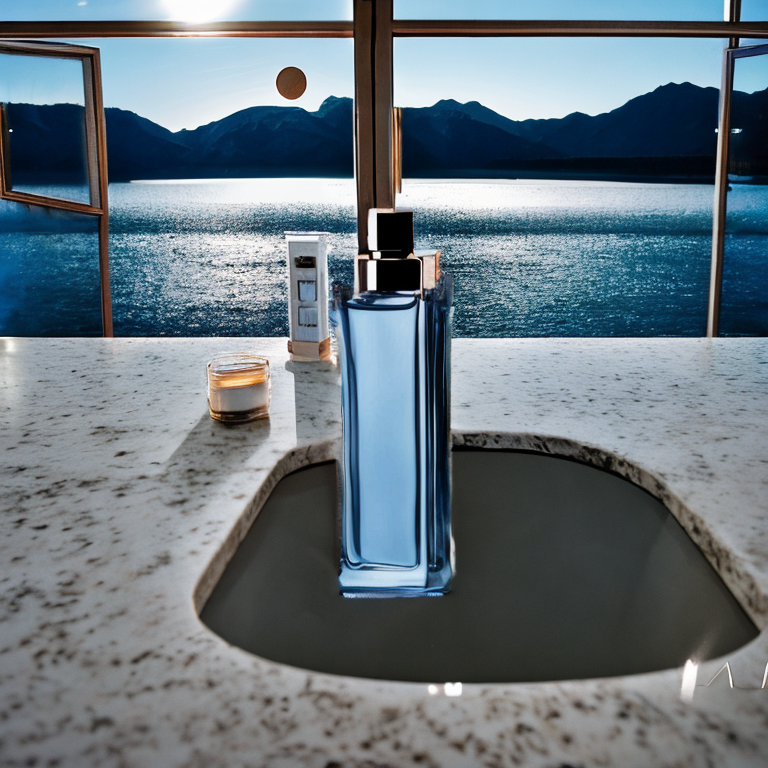

In [ ]:
base64_image = base64.b64decode(final_images["0"])
buffer = BytesIO(base64_image)
image = Image.open(buffer)
image